# Statistical analysis of multilocalizing proteins in cilia vs whole cell

Author: Konstantin Kahnert  
Date: 2024-10-18  
Description: In this notebook we perform a statistical anlysis (Mann Whithey U test) to test if the distribution of the number of subcellular locations of ciliary proteins is significantly different from all proteins in the whole cell. This script was used to create Fig. S2 of the paper "Intrinsic Heterogeneity In Primary Cilia Revealed Through Spatial Proteomics" by Hansen et al. 2024


## Load required packages

In [4]:
# load packages
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

## Load HPA v24 data

In [5]:
# load HPA tsv file
df_hpa = pd.read_table('/mnt/Data/Projects/HPAxTS/protein_panel/proteinatlas_hpa_version24_prerelease.tsv', sep='\t')

df_hpa.head()


,Gene,Gene synonym,Ensembl,Gene description,Uniprot,Chromosome,Position,Protein class,Biological process,Molecular function,...,Cancer prognostics - Pancreatic Adenocarcinoma (TCGA),Cancer prognostics - Pancreatic Adenocarcinoma (validation),Cancer prognostics - Prostate Adenocarcinoma (TCGA),Cancer prognostics - Rectum Adenocarcinoma (TCGA),Cancer prognostics - Rectum Adenocarcinoma (validation),Cancer prognostics - Skin Cuteneous Melanoma (TCGA),Cancer prognostics - Stomach Adenocarcinoma (TCGA),Cancer prognostics - Testicular Germ Cell Tumor (TCGA),Cancer prognostics - Thyroid Carcinoma (TCGA),Cancer prognostics - Uterine Corpus Endometrial Carcinoma (TCGA)
0,TSPAN6,"T245, TM4SF6, TSPAN-6",ENSG00000000003,Tetraspanin 6,O43657,X,100627108-100639991,Predicted membrane proteins,NaN,NaN,...,unprognostic (7.49e-5),unprognostic (1.11e-1),unprognostic (3.30e-2),unprognostic (3.36e-3),unprognostic (4.23e-3),unprognostic (1.89e-2),unprognostic (7.95e-2),unprognostic (2.01e-1),unprognostic (4.60e-2),unprognostic (1.59e-1)
1,TNMD,"BRICD4, ChM1L, myodulin, TEM, tendin",ENSG00000000005,Tenomodulin,Q9H2S6,X,100584936-100599885,Predicted membrane proteins,NaN,NaN,...,NaN,NaN,NaN,unprognostic (2.21e-3),NaN,NaN,NaN,unprognostic (1.55e-1),NaN,NaN
2,DPM1,"CDGIE, MPDS",ENSG00000000419,Dolichyl-phosphate mannosyltransferase subunit...,O60762,20,50934867-50959140,"Disease related genes, Enzymes, Human disease ...",NaN,"Glycosyltransferase, Transferase",...,unprognostic (1.64e-3),unprognostic (1.57e-1),unprognostic (5.86e-2),unprognostic (3.10e-3),unprognostic (7.21e-3),unprognostic (6.73e-2),unprognostic (4.37e-1),unprognostic (1.73e-1),unprognostic (2.03e-3),unprognostic (7.59e-2)
3,SCYL3,"PACE-1, PACE1",ENSG00000000457,SCY1 like pseudokinase 3,Q8IZE3,1,169849631-169894267,"Enzymes, Predicted intracellular proteins",NaN,NaN,...,unprognostic (1.31e-1),unprognostic (2.85e-2),unprognostic (3.03e-1),unprognostic (2.05e-1),unprognostic (1.12e-1),unprognostic (2.20e-1),unprognostic (1.57e-1),unprognostic (1.70e-1),unprognostic (7.81e-2),unprognostic (1.02e-1)
4,C1orf112,FLJ10706,ENSG00000000460,Chromosome 1 open reading frame 112,Q9NSG2,1,169662007-169854080,Predicted intracellular proteins,NaN,NaN,...,unprognostic (2.66e-5),unprognostic (1.12e-2),NaN,unprognostic (2.85e-1),unprognostic (1.25e-1),unprognostic (1.50e-1),unprognostic (1.75e-1),unprognostic (1.68e-1),NaN,unprognostic (1.21e-2)


## Data preprocessing

In [6]:
# remove rows with NaN in the 'Subcellular location' column
df_hpa = df_hpa.dropna(subset=['Subcellular location'])

# merge all ciliary locations
ciliary_locs = ["Primary cilium", "Primary cilium tip", "Primary cilium transition zone"]
 
# Function to combine ciliary locations into "Cilium"
def combine_ciliary_locations(locations, ciliary_locs):
    loc_list = locations.split(',')
    combined_loc_list = ['Cilium' if loc in ciliary_locs else loc for loc in loc_list]
    # Remove duplicates and join back into a single string
    combined_loc_list = list(set(combined_loc_list))
    return ','.join(combined_loc_list)

# Apply the function to the DataFrame
df_hpa['Subcellular location'] = df_hpa['Subcellular location'].apply(combine_ciliary_locations, ciliary_locs=ciliary_locs)

# Display the updated DataFrame
df_hpa['Subcellular location']

0        Nucleoli fibrillar center,Cell Junctions,Cytosol
3                                 Cytosol,Golgi apparatus
4                                    Nucleoplasm,Nucleoli
5                               Aggresome,Plasma membrane
6                                                Vesicles
                               ...                       
20144                        Nucleoplasm,Cytosol,Nucleoli
20145                                Cytosol,Rods & Rings
20147                         Nucleoplasm,Golgi apparatus
20150                                        Mitochondria
20160                                         Nucleoplasm
Name: Subcellular location, Length: 13534, dtype: object

## Count the number of locations for each protein based on subcellular location column

In [7]:
# split string at ","
df_hpa['Subcellular location'] = df_hpa['Subcellular location'].str.split(',')

# replace nan with []
df_hpa['Subcellular location'] = df_hpa['Subcellular location'].fillna('[]')

# count the number of locations
df_hpa['Number of locations'] = df_hpa['Subcellular location'].apply(lambda x: len(x))

In [8]:
df_hpa[['Subcellular location', 'Number of locations']]

,Subcellular location,Number of locations
0,"[Nucleoli fibrillar center, Cell Junctions, Cy...",3
3,"[Cytosol, Golgi apparatus]",2
4,"[Nucleoplasm, Nucleoli]",2
5,"[Aggresome, Plasma membrane]",2
6,[Vesicles],1
...,...,...
20144,"[Nucleoplasm, Cytosol, Nucleoli]",3
20145,"[Cytosol, Rods & Rings]",2
20147,"[Nucleoplasm, Golgi apparatus]",2
20150,[Mitochondria],1


## Filter and analyze ciliary proteins

In [9]:
# get ciliary proteins
df_hpa_cilia = df_hpa[df_hpa['Subcellular location'].apply(lambda x: 'Cilium' in x)]

## Perform Mann Whitney U test to test if the two distributions are significantly different

In [10]:
# test if the two distributions are significantly different

stat, p = mannwhitneyu(df_hpa['Number of locations'], df_hpa_cilia['Number of locations'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')


Statistics=600734.000, p=0.000
Different distribution (reject H0)


In [11]:
p

3.793159089734857e-202

## Visualize distributions and statistical results

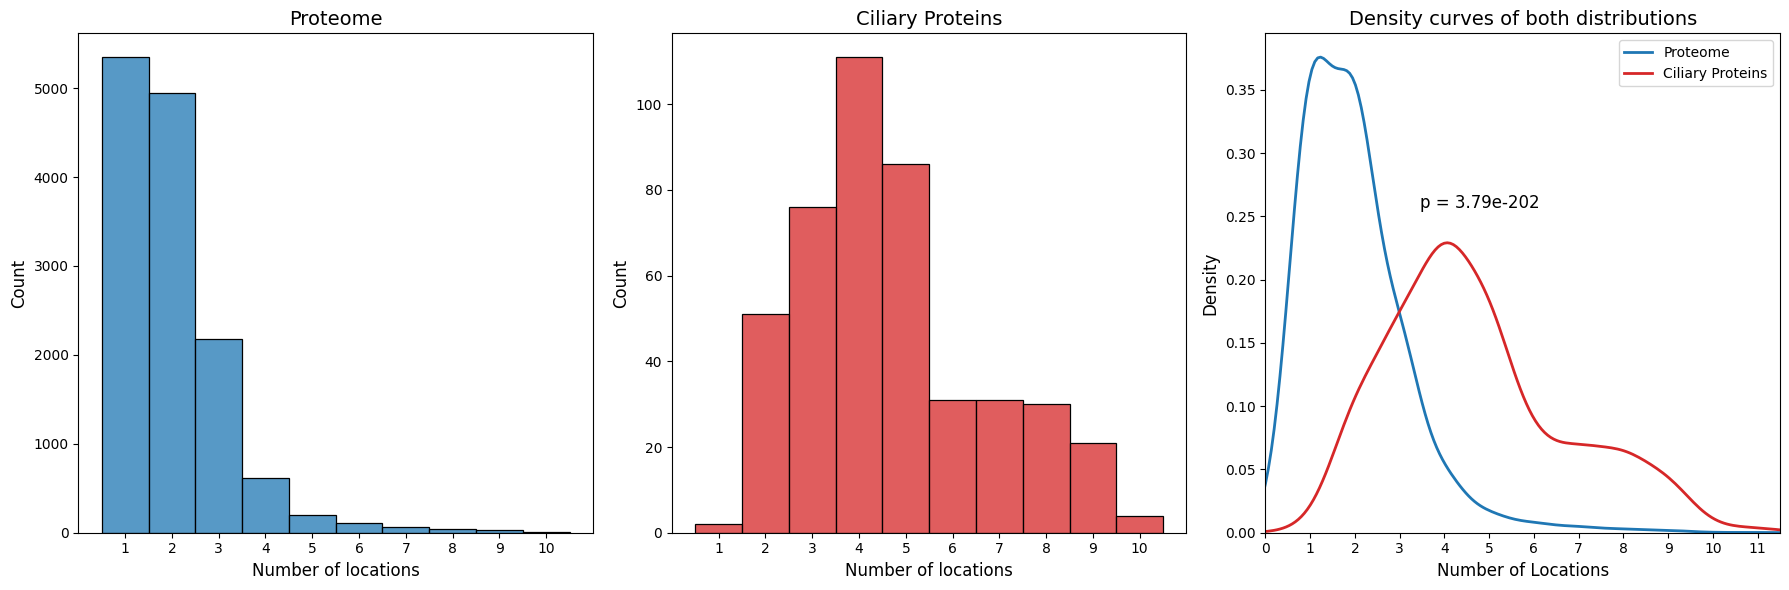

In [12]:
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the first histogram
sns.histplot(df_hpa['Number of locations'], bins=range(1, 12), edgecolor='black', linewidth=0.9, ax=axes[0], color='#1f77b4')
axes[0].set_title('Proteome', fontsize=14)
axes[0].set_xlabel('Number of locations', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Set ticks in the middle of each bar
axes[0].set_xticks([i + 0.5 for i in range(1, 11)])
axes[0].set_xticklabels(range(1, 11))

# Plot the second histogram
sns.histplot(df_hpa_cilia['Number of locations'], bins=range(1, 12), edgecolor='black', linewidth=0.9, ax=axes[1], color='#d62728')
axes[1].set_title('Ciliary Proteins', fontsize=14)
axes[1].set_xlabel('Number of locations', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)

# Set ticks in the middle of each bar
axes[1].set_xticks([i + 0.5 for i in range(1, 11)])
axes[1].set_xticklabels(range(1, 11))

# Plot histograms and smoothed density curves in the third subplot
sns.kdeplot(df_hpa['Number of locations'], bw_adjust=2.8, label='Proteome', color='#1f77b4', ax=axes[2], linewidth=2)
sns.kdeplot(df_hpa_cilia['Number of locations'], bw_adjust=1, label='Ciliary Proteins', color='#d62728', ax=axes[2], linewidth=2)


# add the pvalue as text to the plot
axes[2].text(0.3, 0.65, 'p = {:.2e}'.format(p), transform=axes[2].transAxes, fontsize=12)

# format axis
axes[2].set_xlim(0, 11.5)
axes[2].set_xticks([i for i in range(0, 12)])
axes[2].set_xticklabels(range(0, 12))

axes[2].set_title('Density curves of both distributions', fontsize=14)
axes[2].set_xlabel('Number of Locations', fontsize=12)
axes[2].set_ylabel('Density', fontsize=12)
axes[2].legend()

plt.tight_layout()


# save as svg
plt.savefig('/mnt/Data/Projects/Cilia/Multilocalizing_protein_analysis/distribution_plots_with_pvalue.svg')

plt.show()